# 合并标签
原则上，所有分割算法都有局限性。如果结果不理想，并且没有更好的分割算法可用，后处理标签可能是一种选择。有一些函数可用于根据标签的属性（如标签接触边缘的强度、成对组合标签的像素计数）来合并标签。

In [1]:
import pyclesperanto_prototype as cle
from napari_segment_blobs_and_things_with_membranes import local_minima_seeded_watershed
import numpy as np
cle.select_device("TX")

<NVIDIA GeForce RTX 3050 Ti Laptop GPU on Platform: NVIDIA CUDA (1 refs)>

## 合并接触的标签
最简单的用例可能是合并相互接触的标记对象。

cl.OCLArray([[ 0,  0,  0, ..., 68, 68, 68],
       [ 0,  0,  0, ..., 68, 68, 68],
       [ 0,  0,  0, ..., 68, 68, 68],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
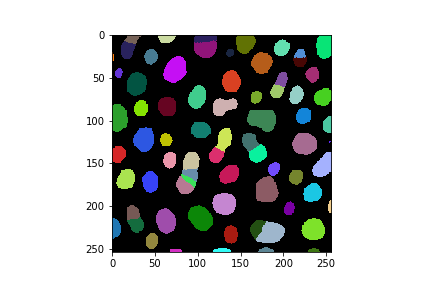

In [2]:
blobs = cle.imread("../../data/blobs.tif")
blobs_labels = cle.voronoi_otsu_labeling(blobs, spot_sigma=3)
blobs_labels

cl.OCLArray([[ 0,  0,  0, ..., 57, 57, 57],
       [ 0,  0,  0, ..., 57, 57, 57],
       [ 0,  0,  0, ..., 57, 57, 57],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
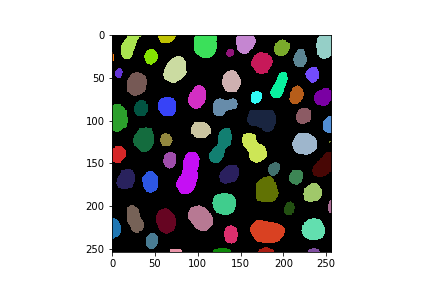

In [3]:
cle.merge_touching_labels(blobs_labels)

## 根据边界强度合并标签
作为示例，我们使用了scikit-image中`cells3d`示例数据集的一个裁剪切片。

cl.OCLArray([[2029., 2518., 2368., ..., 2248., 1888., 1804.],
       [2425., 2415., 2490., ..., 1814., 1977., 2062.],
       [2085., 2293., 2316., ..., 1909., 1789., 1820.],
       ...,
       [3677., 2483., 2423., ..., 2233., 2456., 2359.],
       [2859., 2527., 2547., ..., 1936., 2399., 2111.],
       [2859., 2541., 2510., ..., 2332., 2248., 2066.]], dtype=float32)
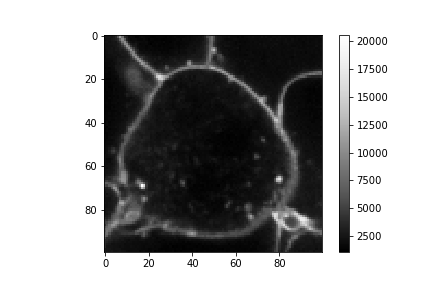
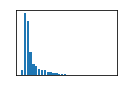

In [4]:
image = cle.imread("../../data/membranes_2d.tif")[30:130, 0:100]
image

在下面的例子中，我们图像中心的细胞被错误地分割为两个细胞：

StackViewNDArray([[ 5,  5,  5, ...,  3,  2,  2],
                  [ 5,  5,  5, ...,  3,  3,  2],
                  [ 5,  5,  5, ...,  3,  3,  3],
                  ...,
                  [11, 11, 11, ..., 12, 12, 12],
                  [11, 11, 11, ..., 12, 12, 12],
                  [11, 11, 11, ..., 12, 12, 12]])
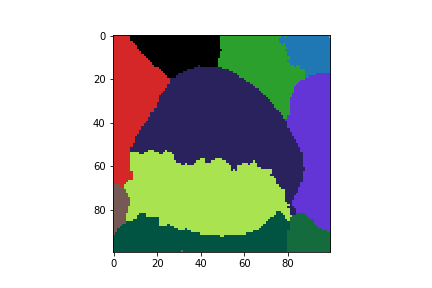

In [5]:
labels = local_minima_seeded_watershed(image, spot_sigma=5, outline_sigma=0)
labels

这可以通过合并边界强度低于给定阈值的细胞来纠正。

c:\structure\code\pyclesperanto_prototype\pyclesperanto_prototype\_tier3\_generate_touch_mean_intensity_matrix.py:30: UserWarning: generate_touch_mean_intensity_matrix is supposed to work with images of integer type only.
Loss of information is possible when passing non-integer images.
  warnings.warn("generate_touch_mean_intensity_matrix is supposed to work with images of integer type only.\n" +


cl.OCLArray([[3, 3, 3, ..., 2, 2, 2],
       [3, 3, 3, ..., 2, 2, 2],
       [3, 3, 3, ..., 2, 2, 2],
       ...,
       [7, 7, 7, ..., 8, 8, 8],
       [7, 7, 7, ..., 8, 8, 8],
       [7, 7, 7, ..., 8, 8, 8]], dtype=uint32)
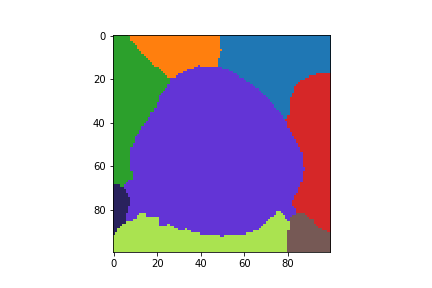

In [6]:
merged_labels = cle.merge_labels_with_border_intensity_within_range(image, labels, maximum_intensity=5000)
merged_labels